In [1]:
import numpy as np;
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

# Aruco Work with Video

In [2]:
cap = cv2.VideoCapture('color.avi')

In [3]:
ret, im = cap.read()

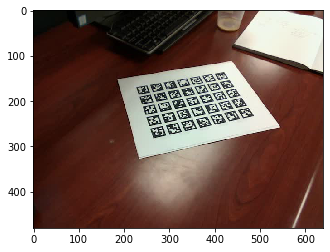

In [4]:
plt.imshow(im[:,:,::-1])
plt.show()

In [5]:
# setup aruco Parameters
arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_50)
arucoParams = cv2.aruco.DetectorParameters_create()

In [6]:
corners, idx, rejected = cv2.aruco.detectMarkers(im, arucoDict, parameters=arucoParams)
drawn = cv2.aruco.drawDetectedMarkers(im, corners, idx)

In [7]:
idx[0]

array([6], dtype=int32)

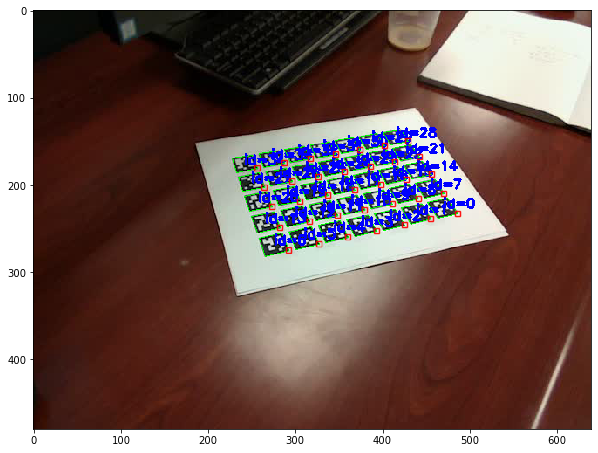

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(drawn[:,:,::-1])
plt.show()

In [9]:
with open('../calibration/intrinsics.npy', 'rb') as f:
    intr = np.load(f)
    dist = np.load(f)

In [10]:
rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, 0.05, intr, dist)

In [11]:
R, _ = cv2.Rodrigues(rvecs[0])
t = tvecs[0].T

In [52]:
def visual(R,t,ax):
    x = np.array([[1,0,0,1]]).T
    y = np.array([[0,1,0,1]]).T
    z = np.array([[0,0,1,1]]).T
    ze = np.array([[0,0,0,1]]).T
    
    transform = np.hstack((R,t))
    
    xt = transform @ x
    yt = transform @ y
    zt = transform @ z
    zet = transform @ ze
    
    vecA = xt - zet
    vecB = yt - zet
    vecC = zt - zet
    #assert (vecA.T @ vecB)[0] <1e-5, f'nonzero dot {(vecA.T @ vecB)[0]}'
    #assert (vecA.T @ vecC)[0] <1e-5, f'nonzero dot {(vecA.T @ vecC)[0]}'
    #assert (vecB.T @ vecC)[0] <1e-5, f'nonzero dot {(vecB.T @ vecC)[0]}'
    
    pts = np.hstack((xt,yt,zt,zet))
    ax.scatter(pts[0,:], pts[1,:], pts[2,:])
    xvec = np.hstack((zet,xt))
    yvec = np.hstack((zet,yt))
    zvec = np.hstack((zet,zt))
    ax.plot(xvec[0,:], xvec[1,:], xvec[2,:],c='blue')
    ax.plot(yvec[0,:], yvec[1,:], yvec[2,:],c='red')
    ax.plot(zvec[0,:], zvec[1,:], zvec[2,:],c='green')

In [106]:
class arucoTest:
        def __init__(self, frame, intr, dist, markerLength = 0.0246153846):
        self.arucoPoseDict = {}
        
        self.arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_50)
        self.arucoParams = cv2.aruco.DetectorParameters_create()
        self.markerLength = markerLength
        
        corners, idx, rejected = cv2.aruco.detectMarkers(frame, self.arucoDict, parameters=self.arucoParams)
        rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, self.markerLength, intr, dist)
        
        self.K = intr
        self.D = dist
        for i in range(idx.shape[0]):
            index = idx[i,0]
            R,_ = cv2.Rodrigues(rvecs[i])
            t = tvecs[i].T
            self.arucoPoseDict[index] = (R,t)
        
    def getPose(self, frame):
        corners, idx, rejected = cv2.aruco.detectMarkers(frame, self.arucoDict, parameters=self.arucoParams)
        rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, self.markerLength, self.K, self.D)
        

        
        avgR = np.zeros((3,3))
        avgT = np.zeros((3,1))
        count = 0
        for i in range(idx.shape[0]):
            index = idx[i,0]
            
            R1,_ = cv2.Rodrigues(rvecs[i])
            t1 = tvecs[i].T
            if index in self.arucoPoseDict.keys():
                R,t = self.arucoPoseDict[index]
                poseR = R.T @ R1
                poseT = t1 - t
                
                avgR += poseR
                avgT += poseT
                count += 1
                
        if count != 0:
            avgR /= count
            avgT /= count
        return avgR, avgT
        

In [107]:
depth_scale = 0.0002500000118743628

In [108]:
im0 = cv2.imread('test_folder/test0.jpg')
im1 = cv2.imread('test_folder/test1.jpg')
im2 = cv2.imread('test_folder/test2.jpg')
im3 = cv2.imread('test_folder/test3.jpg')

In [109]:
test = arucoTest(im0, intr, dist)

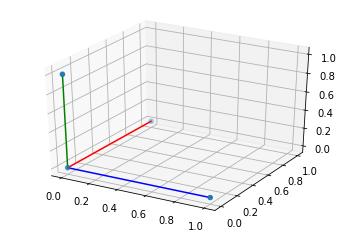

In [112]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

R1,t1 = test.getPose(im1)
R2,t2 = test.getPose(im2)
R3,t3 = test.getPose(im3)
visual(np.eye(3),np.zeros((3,1)),ax)
#visual(R1,np.zeros((3,1)),ax)
#visual(R2,np.zeros((3,1)),ax)
#visual(R3,np.zeros((3,1)),ax)
plt.show()